# Using SpiceyPy to map the ExoMars Rover (RM).
This is just a simple tutorial for using SPICE (SpiceyPy) and some of the standard python libraries to make a map of the ExoMars Rover (RM) position on the surface of Mars for some test data. This is based on Andrew Annex's SpiceyPy MSL Example: https://gist.github.com/AndrewAnnex/f7be18db4ae41620b71c7cf27adbab12 

## Step 1: getting kernels
We get the kernels from the ESS BitBucket

url: https://repos.cosmos.esa.int/socci/projects/SPICE_KERNELS/repos/exomarsrsp/

## Step 2: imports
Relatively self explanatory, we will import spiceypy, numpy, and matplotlib to get started.

In [1]:
import spiceypy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Step 3: Load the kernels
Now we can actually use spiceypy to load the kernels using the furnsh command on the metakernel file, this will load the kernels into the kernel pool for us to use. Please note that most probably you will need to either run this notebook in the metakernel directroy of manually modidy the PATH in the metakernel.

In [2]:
spiceypy.furnsh('/Users/mcosta/SPICE/ExoMarsRSP/kernels/mk/emrsp_test_rec_0003_v001_local.tm')

Let's check to see how many kernels we loaded


In [3]:
spiceypy.ktotal('ALL')

29

## Step 4: Use SpiceyPy to get the longitude and latitude of the rover through time
We will pick a time range from 2021 APR 01 23:01:09.185 to 2021 APR 04 23:01:09.185. I will use linspace to enumerate 500 times between these times so 

In [4]:
solStart = spiceypy.str2et("2021 APR 01 23:01:09.185 UTC")
solEnd = spiceypy.str2et("2021 APR 04 23:01:09.1850 UTC")
times = np.linspace(solStart, solEnd, num=500, endpoint=True)
len(times)

500

Now we obtain the positions using spkpos in SpiceyPy



In [5]:
positions, lttimes = spiceypy.spkpos("EXOMARS ROVER", times, "IAU_MARS", "lt+s", "MARS")
len(positions)

500

Now we need to convert it to lon lat, let's go with planetocentric



In [6]:
r, lon, lat = np.array([spiceypy.reclat(p) for p in positions]).T
lon *= spiceypy.dpr() # you could also just use numpy.degrees for this...
lat *= spiceypy.dpr()

Great, so let's make a simple map to show the traverse. Here we plot the line of points and the marker points for each position, with a colormap corresponding to increasingly yellow through time.

Text(0.5, 1.0, 'RM from 2021 APR 01 to 2021 APR 04')

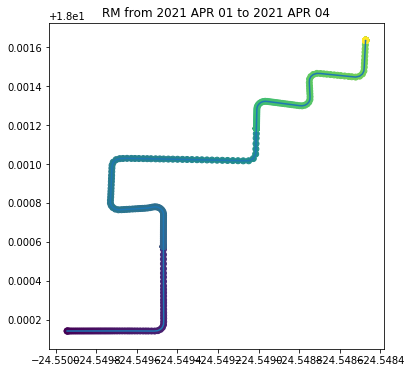

In [7]:
plt.figure(figsize=(6,6))
plt.plot(lon,lat)
plt.scatter(lon,lat, c=times)
plt.title('RM from 2021 APR 01 to 2021 APR 04')

## Step 5: make a very pretty map
Let's make an interactive map with folium. We will be using the USGS Astrogeology center's map layers hosted by ESRI for basemaps. I've included the shaded MOLA+HRSC topography layer, the global CTX mosaic layer, and the uncontrolled (more on this in a bit) HiRISE mosaic layer. Note that there is a significant (hundred+ meters) miss-alignment between where the RM positions are plotted in longitude and latitude from the HiRISE basemap. This is due to the basemap of hirise being produced as a "uncontrolled" mosaic so the placement of the images is not exact. I expect that the position of the rover in longitude and latitude is more correct as the spice kernels I used are from the PDS archive.

In [8]:
import folium

tiles='https://astro.arcgis.com/arcgis/rest/services/OnMars/MColorDEM/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(location=[18.001, -24.549],
               zoom_start=18,
               max_zoom=20,
               tiles=None, 
               crs='EPSG4326')

folium.TileLayer(
    max_native_zoom=7,
    tiles=tiles,
    attr='usgs/esri',
    crs='EPSG4326'
).add_to(m)

ctx = folium.raster_layers.TileLayer(
    tiles='https://astro.arcgis.com/arcgis/rest/services/OnMars/CTX/MapServer/tile/{z}/{y}/{x}',
    max_native_zoom=12,
    attr='usgs/caltech',
    name='ctx', 
    opacity=1,
    overlay=True, 
    control=True,
    crs='EPSG4326'
)
ctx.add_to(m)

hirise = folium.raster_layers.TileLayer(
    tiles='https://astro.arcgis.com/arcgis/rest/services/OnMars/HiRISE/MapServer/tile/{z}/{y}/{x}',
    max_native_zoom=17,
    attr='usgs/esri',
    name='hirise', 
    opacity=1,
    overlay=True, 
    control=True,
    crs='EPSG4326'
)
hirise.add_to(m)

# add points from positions
utc_times = spiceypy.et2utc(times, 'C', 0)
folium.PolyLine(list(zip(lat, lon)), color='green').add_to(m)
for i, (lo, la) in enumerate(list(zip(lon,lat))[::10]):
    folium.Marker((la, lo), tooltip=f'{utc_times[i]}').add_to(m)
folium.LayerControl().add_to(m)
m